## Comparison between ElasticNet, L1L2 and parsimony's ElasticNet

Regression problem.
Each dataset is generated `ntrials` times, and the three methods are evaluated.

To be comparable, we set the `fit_intercept` parameter of ElasticNet and L1L2 to be `False`, since parsimony does not currently offer the support for a `fit_intercept=True`.
In addition, also results using `fit_intercept=True` are shown for ElasticNet and L1L2.

Actually, this does not seem to heavily affect the solution, at least in this synthetic problem.

In [40]:
import time
import numpy as np

from palladio.wrappers import ElasticNetClassifier
from l1l2py.classification import L1L2Classifier

from sklearn.linear_model import ElasticNet
import parsimony.estimators as estimators
import parsimony.algorithms as algorithms
from l1l2py.linear_model import L1L2

from sklearn.datasets import make_classification, make_regression
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns

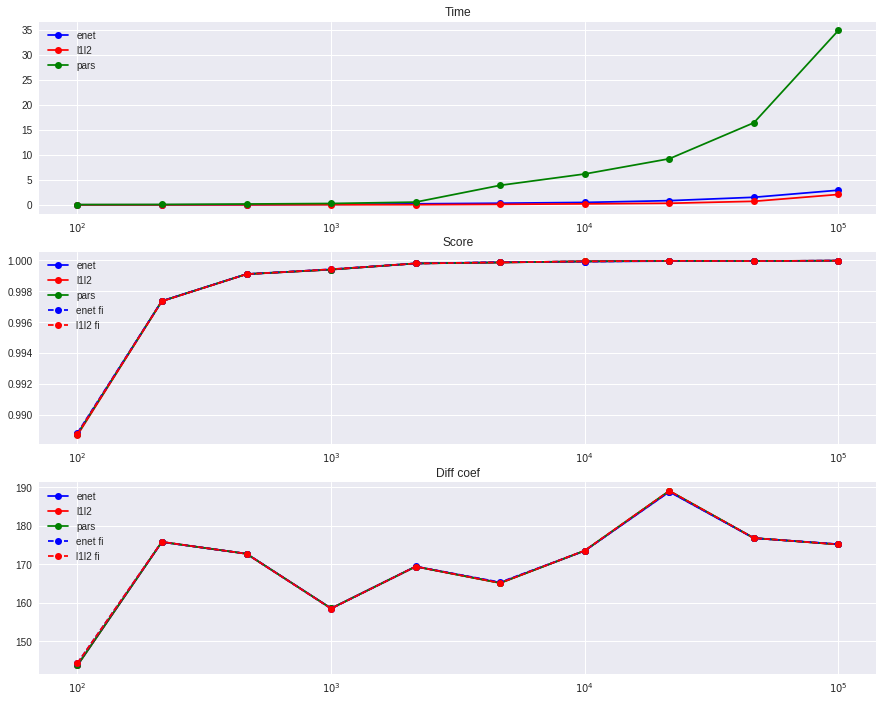

In [76]:
dims = map(int, np.logspace(2, 5, 10))
ntrials = 3

time_enet = np.zeros(len(dims))
time_l1l2 = np.zeros(len(dims))
time_pars = np.zeros(len(dims))

score_enet = np.zeros(len(dims))
score_l1l2 = np.zeros(len(dims))
score_pars = np.zeros(len(dims))
score_enet_fi = np.zeros(len(dims))
score_l1l2_fi = np.zeros(len(dims))

# difference between coef and coef_star
diff_enet = np.zeros(len(dims))
diff_l1l2 = np.zeros(len(dims))
diff_pars = np.zeros(len(dims))
diff_enet_fi = np.zeros(len(dims))
diff_l1l2_fi = np.zeros(len(dims))


for i, dim in enumerate(dims):
    for j in range(ntrials):
        X, y, coef_star = make_regression(
            n_samples=20, n_features=dim,
            # n_informative=10, n_classes=2, shuffle=False,
            n_informative=10, shuffle=False, coef=True, noise=0.4)

        tic = time.time()
    #        coef_enet = ElasticNetClassifier(l1_ratio=1, alpha=.125).fit(X,y).coef_
        enet = ElasticNet(fit_intercept=False).fit(X,y)
        coef_enet = enet.coef_

        tac = time.time()
        dt_enet = tac-tic

        tic = time.time()
        l1l2 = L1L2(fit_intercept=False).fit(X,y)
        coef_l1l2 = l1l2.coef_
        tac = time.time()
        dt_l1l2 = tac-tic

        tic = time.time()
        # coef_l1l2 = L1L2Classifier(mu=0, tau=.25).fit(X,y).coef_
        pars = estimators.ElasticNet(l=.5, alpha=1, algorithm=algorithms.proximal.FISTA()).fit(X,y)
        coef_pars = pars.beta.ravel()
        tac = time.time()
        dt_pars = tac-tic
        
        tic = time.time()
    #        coef_enet = ElasticNetClassifier(l1_ratio=1, alpha=.125).fit(X,y).coef_
        enet_fi = ElasticNet(fit_intercept=True).fit(X,y)
        coef_enet_fi = enet_fi.coef_

        tac = time.time()
        dt_enet_fi = tac-tic

        tic = time.time()
        l1l2_fi = L1L2(fit_intercept=True).fit(X,y)
        coef_l1l2_fi = l1l2_fi.coef_
        tac = time.time()
        dt_l1l2_fi = tac-tic

        time_enet[i] += dt_enet
        time_l1l2[i] += dt_l1l2
        time_pars[i] += dt_pars
        
        diff_enet[i] += np.linalg.norm(coef_star - coef_enet)
        diff_l1l2[i] += np.linalg.norm(coef_star - coef_l1l2)
        diff_enet_fi[i] += np.linalg.norm(coef_star - coef_enet_fi)
        diff_l1l2_fi[i] += np.linalg.norm(coef_star - coef_l1l2_fi)
        diff_pars[i] += np.linalg.norm(coef_star - coef_pars)

    #print(coef_enet)
    #print(coef_l1l2)
    #print("Time ELAPSED ENET: {}".format(dt_enet))
    #print("Time ELAPSED L1L2: {}".format(dt_l1l2))
    #print(np.allclose(coef_enet, coef_l1l2, atol=1.e-3))
    
    
        score_enet[i] += enet.score(X,y)
        score_l1l2[i] += l1l2.score(X,y)
        score_enet_fi[i] += enet_fi.score(X,y)
        score_l1l2_fi[i] += l1l2_fi.score(X,y)

        y_pred = pars.predict(X)
        score_pars[i] += r2_score(y, y_pred)

time_enet /= ntrials
time_l1l2 /= ntrials
time_pars /= ntrials
score_enet /= ntrials
score_l1l2 /= ntrials
score_pars /= ntrials
diff_enet /= ntrials
diff_l1l2 /= ntrials
diff_enet_fi /= ntrials
diff_l1l2_fi /= ntrials
diff_pars /= ntrials

score_enet_fi /= ntrials
score_l1l2_fi /= ntrials

plt.figure(figsize=(15,12))
plt.subplot(311)
plt.semilogx(dims, time_enet, 'b-o', label='enet')
plt.semilogx(dims, time_l1l2, 'r-o', label='l1l2')
plt.semilogx(dims, time_pars, 'g-o', label='pars')
plt.title("Time")
plt.legend()

plt.subplot(312)
plt.semilogx(dims, score_enet, 'b-o', label='enet')
plt.semilogx(dims, score_l1l2, 'r-o', label='l1l2')
plt.semilogx(dims, score_pars, 'g-o', label='pars')
plt.semilogx(dims, score_enet_fi, 'b--o', label='enet fi')
plt.semilogx(dims, score_l1l2_fi, 'r--o', label='l1l2 fi')
plt.title("Score")
plt.legend()

plt.subplot(313)
plt.semilogx(dims, diff_enet, 'b-o', label='enet')
plt.semilogx(dims, diff_l1l2, 'r-o', label='l1l2')
plt.semilogx(dims, diff_pars, 'g-o', label='pars')
plt.semilogx(dims, diff_enet_fi, 'b--o', label='enet fi')
plt.semilogx(dims, diff_l1l2_fi, 'r--o', label='l1l2 fi')
plt.title("Diff coef")
plt.legend()

plt.show()